# Вебинар 4. Обучение с учителем.

**План занятия**
* [Введение](#intro)
* [Шаг 1. Загрузка данных](#load)
* [Шаг 2. EDA и очистка данных](#eda)
* [Шаг 3: Очистка данных и Feature engineering](#preprocess)
* [Шаг 4. Разбиение на train / test](#split)
* [Шаг 5. Построение моделей](#model)
    * [5.1 Linear Regression](#linear)
    * [5.2 Decision tree](#tree)
    * [5.3 Random Forest](#rf)
    * [5.4 Gradient Boosting decision trees](#boost)
* [Шаг 6. Настройка и оценка финальной модели](#cross_val)
* [Шаг 7. Анализ прогнозов](#pred)
* [Шаг 8. Сохранение модели](#save)
* [Обобщение](#full)

## Введение <a class='anchor' id='intro'>

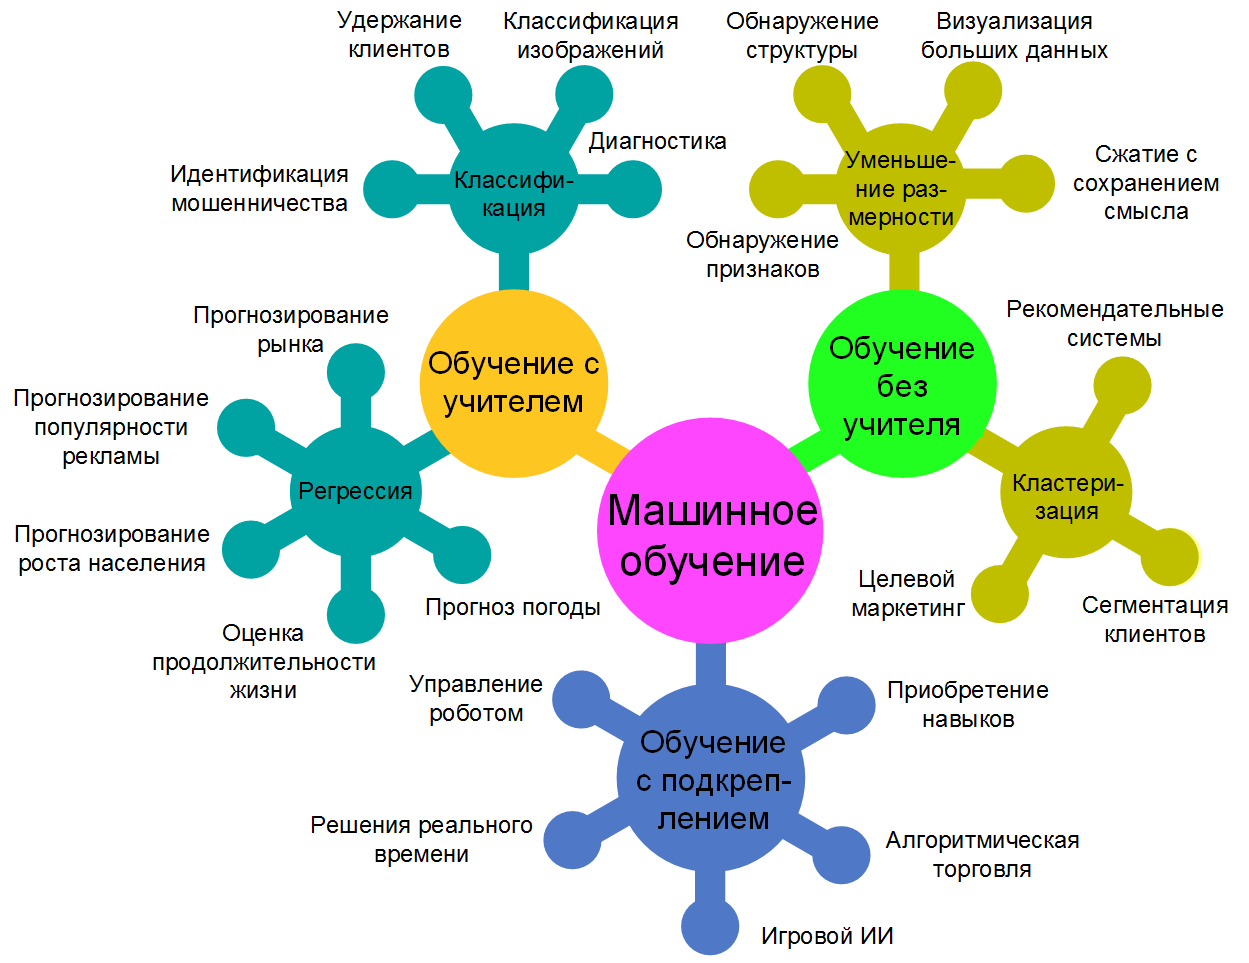 

**Обучение с учителем** = есть целевая переменная (таргет), которую мы предсказываем

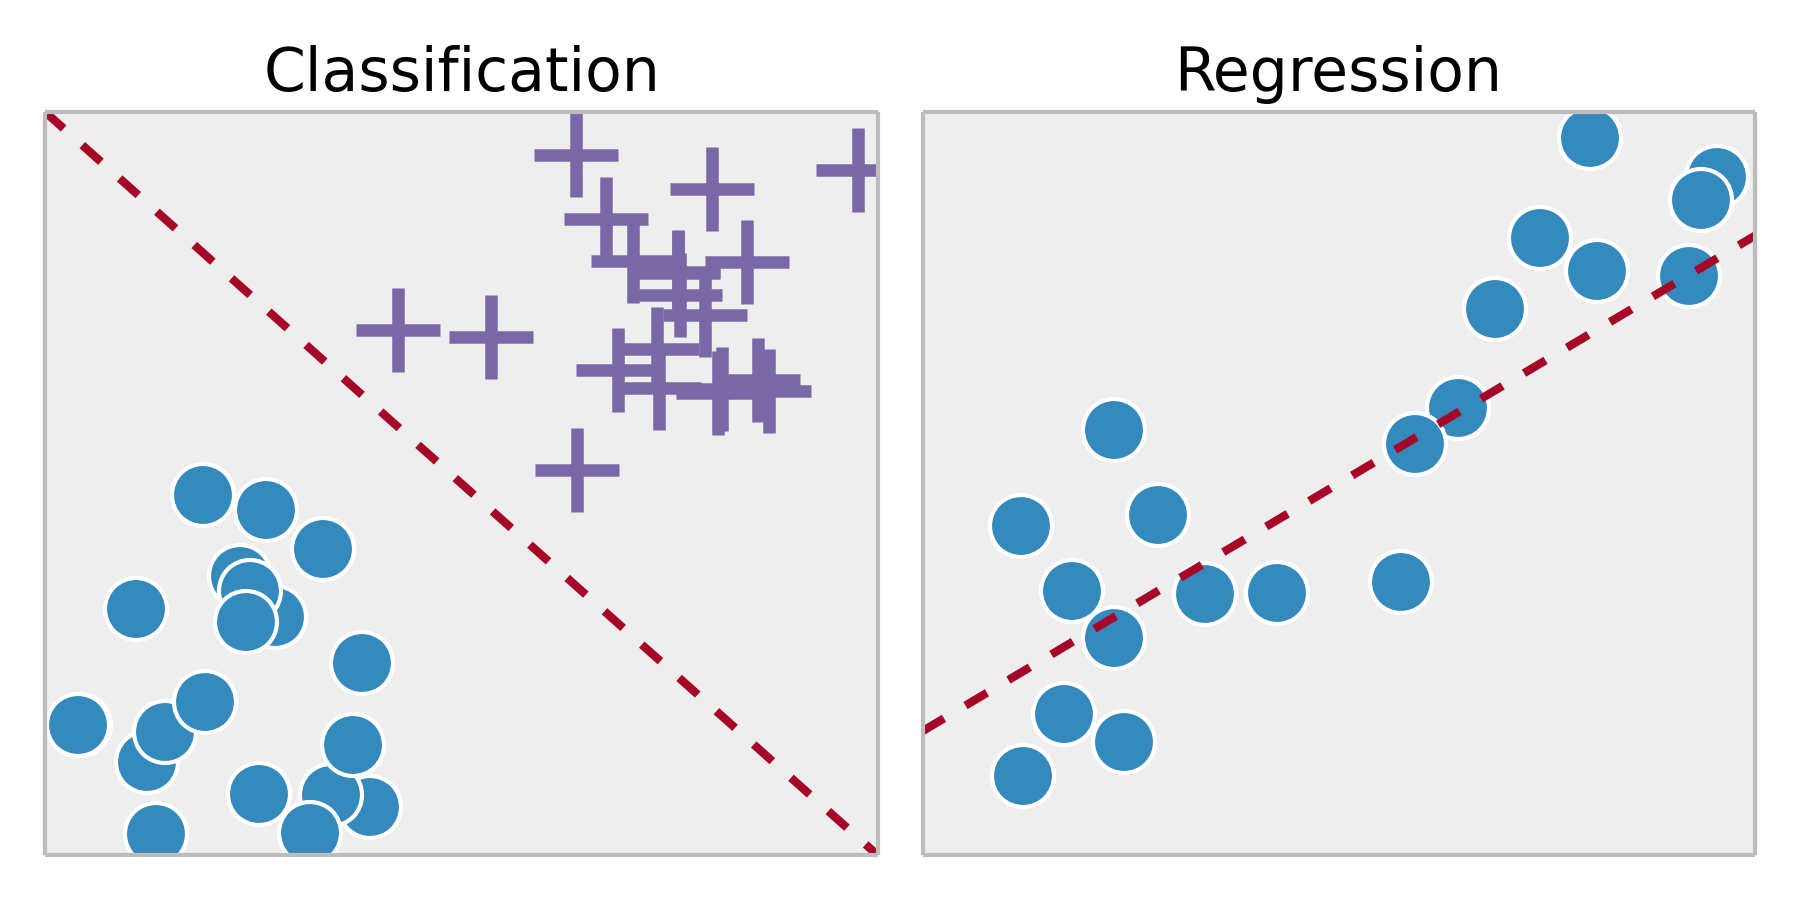

_Регрессия_ - таргет непрерывен
- Предсказание цен на дома
- Предсказание спроса на товары
- ...


_Классификация_ - Таргет принимает 2 (иногда k) значений
- Кредитный скоринг: вернет кредит (target=0) или нет (target=1)
- Определение вида животного по фото (0 - лев, 1 - пантера, 2 - леопард, ... , k - гепард) 
- ...

**Обучение без учителя** = нет целевой переменной:
- Разделение данных на группы
- ...
_______________

**Обучение с подкреплением** - испытуемая система (агент) обучается, взаимодействуя с некоторой средой.
<table><tr>
<td> <img src="images/openai1.gif" style="width: 600px;"/> </td>
<td> <img src="images/unnamed.gif" style="width: 450px;"/> </td>
</tr></table>

_________
**Что относится к классификации?**<br>
1. Прогноз оценки студента по пятибалльной шкале на экзамене 
2. Предсказание спроса на товары
3. Поиск похожих групп пользователей
4. Разделение книг на художественные и научные

---

**ЭТАПЫ Data Science проекта:**
1. Определить бизнес проблему
2. Убедить бизнес, что ее можно и нужно решать с помощью ML
3. Перевести бизнес проблему в ML-задачу
4. Выбрать подходящие ML и бизнес метрики
---------------------------------------------------------------------------
5. Загрузка данных
6. EDA: визуализация данных (вебинар 3)
7. Очистка данных и feature engineering (вебинар 2)
8. **_Разбиение данных на train и test_**
9. **_Построение ML моделей_**
10. **_Оценка качества ML моделей и выбор наилучшей_**

---------------------------------------------------------------------------
11. Доказать бизнес-заказчику, что модель хорошо работает
12. Внедрение модели в production
13. Улучшение модели
14. Поддержка модели

---

**Подключение библиотек и скриптов**

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [3]:
DATASET_PATH = './housing.csv'
PREPARED_DATASET_PATH = './housing_prepared.csv'

REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

# Шаг 1. Загрузка данных <a class='anchor' id='load'>

По **reduce_mem_usage** смотри вебинар 3

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [5]:
df = pd.read_csv(DATASET_PATH, sep=';')
df = reduce_mem_usage(df)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: './housing.csv'

In [ ]:
df.dtypes

# Шаг 2. EDA и очистка данных  <a class='anchor' id='eda'>

*В этом вебинаре мы не будем останавливаться на EDA, но в проекте это сделать нужно - __смотри вебинар 3__

In [ ]:
plt.figure(figsize = (16, 8))

df['median_house_value'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('median_house_value')

plt.title('Distribution of median_house_value')
plt.show()

In [ ]:
df = df[df['median_house_value'] <= 500000].reset_index()

In [ ]:
plt.figure(figsize = (16, 8))

df['median_house_value'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('median_house_value')

plt.title('Distribution of median_house_value')
plt.show()

# Шаг 3: Очистка данных и Feature engineering  <a class='anchor' id='preprocess'>

*Пример вы можете посметреть в вебинаре 2: __class DataPipeline__

In [ ]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        # <your code>
        
    def fit(self, df):
        """Сохранение статистик"""
        # <your code>
        
    def transform(self, df):
        """Трансформация данных"""
        # <your code>

---

**Оставим признаки, которые необходимы для модели**

In [ ]:
df.columns.tolist()

In [ ]:
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                 'households', 'median_income', '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN']

target_name = 'median_house_value'

In [ ]:
df = df[feature_names + [target_name]]
df.head()

**Стандартизация признаков** 

In [ ]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['float32', 'float16']).columns.tolist()
feature_names_for_stand

In [ ]:
# MinMaxScaler() Для каждой фичи x делает: (x - min) / (max - min) -> [0, 1]
# StandardScaler() Для каждой фичи х делает: (x - mean) / std      -> mean = 0, std = 1

scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [ ]:
stand_features

In [ ]:
stand_features.shape

In [ ]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [ ]:
df.head()

### Сохранение  датасета

In [ ]:
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=';')

# Шаг 4. Разбиение на train / test  <a class='anchor' id='split'>

In [ ]:
X = df[feature_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

# Шаг 5. Построение моделей <a class='anchor' id='model'>

    
ML метрика - Mean Squared Error (**MSE**) 
    - MSE прямопропорциональна RMSE и R^2
    - MSE  удобно оптимизировать (брать производные)
    - MSE используется "под капотом" наших ML моделей



Бизнес метрика - **R^2**, Root Mean Squared Error (**RMSE**)
    - Бизнес метрика интерпретируема
    - Понятна бизнесу
    - Ее мы показываем бизнесу
    - RMSE - насколько, в среднем, $ мы ошибаемся при предсказании цен 
    - R^2 принимает значения от 0 до 1, если 1 - все предсказания идеальны. Можно сказать, что это "точность" модели

Лучшая модель - модель с наименьшей MSE на test 

 $$MSE = \frac{1}{n}  \sum{(y - y_{pred})^2}$$

$$RMSE = \sqrt{\frac{1}{n}  \sum{(y - y_{pred})^2}}$$

$$R^2 = 1 - \frac{\frac{1}{n}\sum{(y - y_{pred})^2}}{\frac{1}{n}\sum{(y - y_{mean})^2}}$$

In [ ]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### 5.1 Linear Regression  <a class='anchor' id='linear'>

<img src='images/linear_reg.png' width=500px>

$$price_{pred} = a_0 + a_1 * households + a_2 * rooms$$

Подробное объяснение [здесь](https://codecamp.ru/blog/introduction-to-linear-regression-python/)

$$Loss = MSE = \frac{1}{n}\sum{(price - price_{pred})^2}$$

$$Loss = MSE = \frac{1}{n}\sum{(price - (a_0 + a_1 * households + a_2 * rooms))^2}$$

$dx^2 = 2x$

$d4x = 4$

Находим производные по параметрам и решим систему из 3 уравнений с 3 неизвестными:

$$\frac{dLoss}{da_0} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * 1} = 0 $$  
$$\frac{dLoss}{da_1} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * households} = 0 $$  
$$\frac{dLoss}{da_2} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * rooms} = 0 $$  

In [ ]:
# np.clip([-10, 1, 100000, 1000000], a_min=10000, a_max=500000)

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
# Постпроцессинг
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = lr_model.predict(X_test)

# Постпроцессинг
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)

evaluate_preds(y_test, y_test_preds)

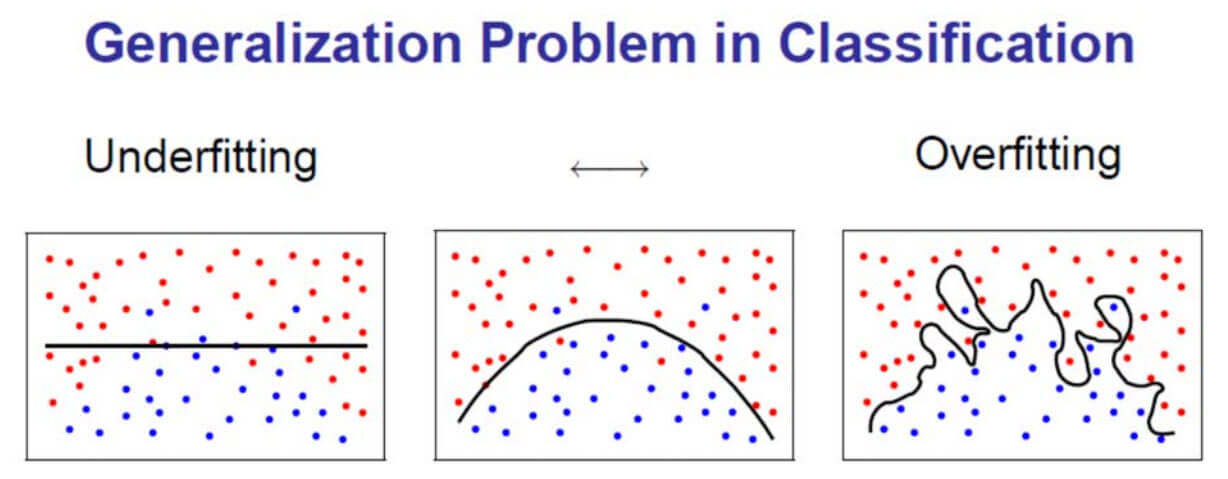

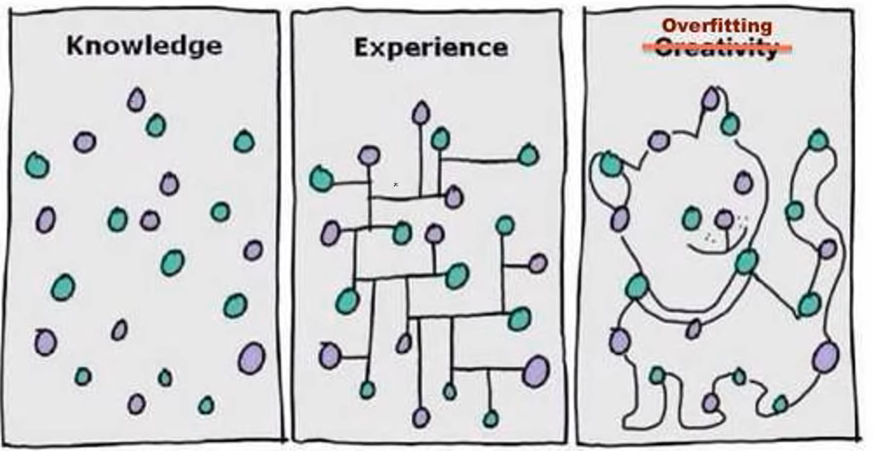

### 5.2 Decision tree  <a class='anchor' id='tree'>

Подробнее можно почитать [здесь](https://habr.com/ru/company/ods/blog/322534/)

На примере задачи: _Сколько времени человек потратит на онлайн игры?_  (0 - 24 часа/день)

<img src='images/dt_explained.png'>

- age < 15 and is_male > 0.5 ---> 5
- age < 15 and is_male <= 0.5 ---> 0
- age >= 15 ---> 1

Decision tree может моделировать зависимости такого вида:

<img src='images/dt_example.png'>

In [ ]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=400, # глубина дерева  
                                 min_samples_leaf=1, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42)
dt_model.fit(X_train, y_train)

y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = dt_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns, filled = True);

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X_train.columns, filled = True, max_depth=2);

### 5.3 Random Forest  <a class='anchor' id='rf'>

Про лес подробнее можно почитать [здесь](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)

**Независимо** строятся N деревьев. Их **предсказания усредняются**

Чтобы деревья получались разными добавляют элемент случайности:
- каждое дерево строят на подвыборке данных (случайно сэмплируют 70% данных)
- каждое дерево строят на подвыборке фич (случайно сэмплируют 70% фич)
- ...

<img src='images/rf_explained.png'>

Бутстрэп - выбираем из обучающей выборки k объектов с возвращением.
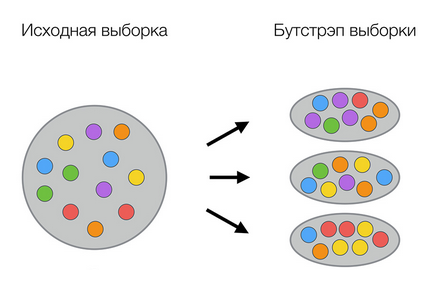
Бэггинг - Бутстрэп-агрегирование<br>
Про бэггинг и бутстрэп можно почитать [здесь](https://habr.com/ru/company/ods/blog/324402/)

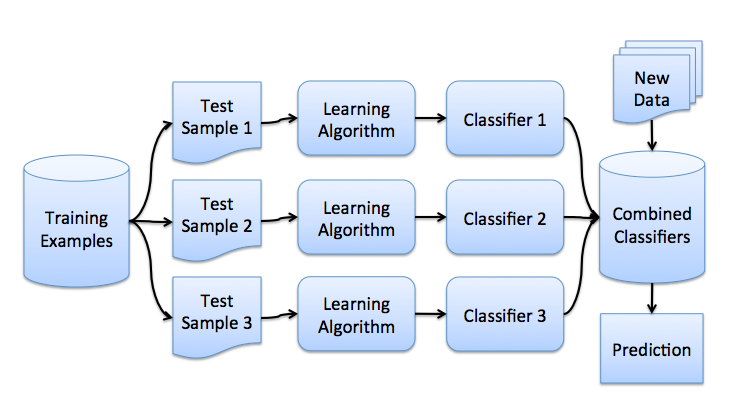

In [ ]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=100  # кол-во деревьев
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### 5.4 Gradient Boosting decision trees  <a class='anchor' id='boost'>

Подробнее можно почитать [здесь](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d)

**Последовательно** строятся N деревьев: новое дерево обучается на ошибках предыдущих. **Предсказания деревьев суммируются**

<img src='images/gb_explained.png'>

In [ ]:
y = np.array([10, 20, 30, 5, 10])

# Первое дерево
y_pred_1 = np.array([8, 25, 34, 10, 3])
error_1 = y - y_pred_1

error_1

In [ ]:
gb_pred = y_pred_1
r2(y, gb_pred)

In [ ]:
# Второе дерево: таргет = ошибки первого (error_1)
y_2 = error_1
y_pred_2 = np.array([1, -4, -2, -1, 3])

error_2 = y_2 - y_pred_2
error_2

In [ ]:
gb_pred = y_pred_1 + y_pred_2
r2(y, gb_pred)

In [ ]:
# Третье дерево: таргет = ошибки второго (error_2)
y_3 = error_2
y_pred_3 = np.array([0, -1, -1, -1, 1])

error_2 = y_3 - y_pred_3
error_2

In [ ]:
gb_pred = y_pred_1 + y_pred_2 + y_pred_3
r2(y, gb_pred)

---

In [ ]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

# Шаг 6.* Настройка и оценка финальной модели  <a class='anchor' id='cross_val'>

!!!  кросс-валидация проходит на трейне, test не трогаем  !!!

[Кросс валидация](https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85) и подбор гиперпараметров

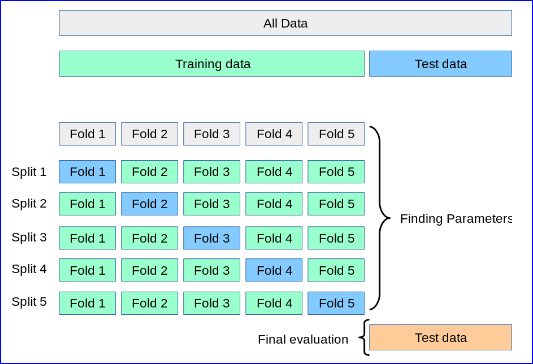

In [ ]:
X_train.shape[0] // 5

In [ ]:
X_train.reset_index(inplace=True, drop=True)
y_train = pd.DataFrame(y_train).reset_index(drop=True)

In [ ]:
# Одну модель (одни и те же гиперпараметры)

# Iteration_1
X_train__val_1 = X_train.iloc[:2500]
y_train__val_1 = y_train.iloc[:2500]

X_train__train_1 = X_train.iloc[2500:]
y_train__train_1 = y_train.iloc[2500:]


# обучаем модель на X_train__train_1, y_train__train_1
# предсказываем на X_train__val_1, y_train__val_1
# R2__1 = r2(y_pred__val_1, y_train__val_1) = 0.83


# Iteration_2
X_train__val_2 = X_train.iloc[2500:5000]
y_train__val_2 = y_train.iloc[2500:5000]

X_train__train_2 = X_train.drop(np.arange(2500, 5000))
y_train__train_2 = y_train.drop(np.arange(2500, 5000))


# обучаем модель на X_train__train_2, y_train__train_2
# предсказываем на X_train__val_2, y_train__val_2
# R2__2 = r2(y_pred__val_2, y_train__val_2) = 0.87


# ...

# R2 = [0.83, 0.87, 0.79, 0.8, 0.91]

In [ ]:
R2 = np.array([0.83, 0.87, 0.79, 0.8, 0.91])
np.mean(R2)

In [ ]:
# Сделали то же самое для модели с другими гиперпараметрами

In [ ]:
# cross val R2 model_1 = 0.84
# cross val R2 model_2 = 0.87 - выбираем эту модель (ее гиперпараметры)

In [ ]:
# ЗАНОВО Обучаем модель с наилучшими гиперпараметрами (те, которые дают максимальный cross val R2) на ВСЕМ train

---

In [ ]:
gb_model = GradientBoostingRegressor(criterion='mse',
                          min_samples_leaf=10,
                          random_state=42,
                         # n_estimators=100,
                         # max_depth=7
                         )

In [ ]:
%%time
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame(gs.cv_results_)
res.head(2)

In [ ]:
gs.best_params_

In [ ]:
gs.best_score_

**Обучение и оценка модели**

In [ ]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=400)

final_model.fit(X_train, y_train)

In [ ]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(np.squeeze(y_train.values), y_train_preds)

In [ ]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds, save=True)

# Шаг 7.* Анализ прогнозов <a class='anchor' id='pred'>

**Важность признаков**

In [ ]:
final_model.feature_importances_

In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

**Топ-3 фичи**

In [ ]:
feature_importances.head(3)

**Худшие 3 фичи**

In [ ]:
feature_importances.tail(3)

In [ ]:
feature_importances.to_csv(REPORTS_FILE_PATH + 'feature_importances.csv', index=False)

# Шаг 8. Сохранение модели <a class='anchor' id='save'>

In [ ]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [ ]:
with open(MODEL_FILE_PATH, 'rb') as file:
    my_model = pickle.load(file)
    
my_model

In [ ]:
import sklearn
print(sklearn.__version__)

In [ ]:
pip freeze

# Обобщение  <a class='anchor' id='full'>

----

## $$Метрики$$
<img src='images/classif&regr.png'>

In [ ]:
from sklearn.ensemble import BaggingRegressor, VotingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

x = [[1, 2, 3], [1, 2, 3], [1, 2, 3]]
y = [0, 10, 15]
knn = KNeighborsRegressor(n_neighbors=1)
c = BaggingRegressor(knn, base_estimator=100)
c.fit(x, y)
c.predict(x)

[Машинное обучение для людей](https://zen.yandex.ru/media/id/5c228ab268a70a00adaf792a/mashinnoe-obuchenie-dlia-liudei-5c23782132121100a94a4417)
<img src=https://avatars.mds.yandex.net/get-zen_doc/1056701/pub_5c23782132121100a94a4417_5c2378bab8997d00a95fbbcc/scale_2400 width=800px>

___________
<img src='images/ds_pipeline.png'>

## Курсовая
**Требования к курсовому:**

Нужно будет оформить ноутбук с основными этапами:
1. подготовка данных
    * анализ
    * визуализация
    * обработка выбросов
    * обработка пропусков
    * генерация фичей
2. обучение модели
3. проверка качества модели

Так же надо отправить файл с предсказаниями на kaggle и на private leaderboard получить больше 0.6

Данные для курсового можно брать отсюда https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528 (вкладка data)


________________________
За шаблон оформления курсовой можно взять ноутбук, который будем разбирать на уроке 10: https://www.kaggle.com/julichitai/baseline


*Что обязательно стоит попробовать:*
1. Тщательный анализ данных
2. Поиск странных значений
3. Предобработка данных
4. Генерация разнообразных признаков
5. Разные модели и их разные гиперпараметры

*Что не стоит пробовать:*
1. Кластеризация
2. Модели понижения размерности